In [ ]:
import cv2
import time
import numpy as np

import math
import copy
from pathlib import Path

import matplotlib.pyplot as plt

In [23]:
def extract_and_affine_to_target(img, target_shape):
    #wt, ht = target_shape
    ht, wt = target_shape
    h, w = img.shape
    f = min(wt / w, ht / h)
    tx = (wt - w * f) / 2
    ty = (ht - h * f) / 2

    #print(tx, ty, ht, wt, h, w, f)
    # warp/map image into target image
    #should we make more horizontal too?
    M = np.float32([[f, 0, tx], [0, f, ty]])
    #target = np.ones(target_shape[::-1]) * 255 / 2  #puts (h,w) into array [w,h] ???
    #target =  img.copy() #np.ones(target_shape[::-1]) * 255 / 2 #gray at 127
    target = np.ones((ht,wt)) * 0  #rows,cols = h, w  0=black 255=white
    target = cv2.warpAffine(img, M, dsize=(wt,ht), borderMode=cv2.BORDER_TRANSPARENT)  #(width,height!!!)
    return target

def extract_and_warp_to_patch(source_image, r, c, w, h, dst_shape):
    #r will usually be a "y" value from CV2 points
    #c will usually be a "x" value from CV2 points

    #image.shape ==> numpy.shape == rows, cols, colors
    #cv2.size() ==> cols, rows (e.g. x, y)

    dh, dw = dst_shape #shape is matrix reference -> rows,cols -> h,w on image

    ptsS = np.float32([[r,c],[r,c+w],[r+h,c+w],[r+h,c]]) #pts are returned as (col,row) in the matrix -> m[row,col]
    ptsD = np.float32([[[0,0],[0,dw],[dh,dw],[dh,0]]])

    M = cv2.getPerspectiveTransform(ptsS,ptsD)
    patch = cv2.warpPerspective(source_image,M, (dw,dh)) #points and size go as (x,y) and/or (cols,rows)
    return patch

def extract_and_warp_to_patch_corners(source_image, x0,y0, x1,y1, x2, y2, x3,y3, dst_shape):
    #x0,y1 = UPPER left corner (lowest x, lowest y)
    #rotate CW

    #image.shape ==> numpy.shape == rows, cols, colors
    #cv2.size() ==> cols, rows (e.g. x, y)

    dh, dw = dst_shape #shape is matrix reference -> rows,cols -> h,w on image

    ptsS = np.float32([[x1,y1],[x2,y2],[x3,y3], [x0,y0]]) #pts are returned as (col,row) in the matrix -> m[row,col]
    ptsD = np.float32([[[0,0],[0,dw],[dh,dw],[dh,0]]])

    M = cv2.getPerspectiveTransform(ptsS,ptsD)
    patch = cv2.warpPerspective(source_image,M, (dw,dh)) #points and size go as (x,y) and/or (cols,rows)
    return patch


In [26]:
#version using standard rectangle

image = cv2.imread("test_text_4.jpg")
image2 = image.copy()
#targets = np.zeros()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#blurred = gray
binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

edged = cv2.Canny(blurred, 10, 200)
#binary2 = cv2.threshold(edged.copy(), 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

cnts_1, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #external with canny?

t_wide = 1200
t_high = 800
target = np.zeros((t_high, t_wide), gray.dtype)
target2 = np.zeros((t_high, t_wide), gray.dtype)
p_wide = 80
p_high = 120
nx1, ny1 = (0,0)
nx2, ny2 = (0,0)
gap = 40

keep_rec = []
keep_tight_rec = []

for cnum, cnt in enumerate(cnts_1):
	x,y,w,h = cv2.boundingRect(cnt)  #is really col,row,w,h ??
	
	#try with the minArea (rotated) rect
	min_rect = cv2.minAreaRect(cnt)
	((c1, c2), (mw, mh), angle) = min_rect
	box = cv2.boxPoints(min_rect)
	box = np.int0(box)

	#br = min_rect.boundingRect()
	#br = cv2.boundingRect(min_rect)
	#print(f"w,h:{w},{h} mw,mh,angle:{mw},{mh}, {angle}")

	if w > 5 and h > 5:  #ignore tiny noise rectangles
		keep_rec.append( (x,y,w,h, box, mw, mh, angle) )
		keep_tight_rec.append( (box, mw, mh, angle) )

keep_rec = sorted(keep_rec, key=lambda r:(r[1]), reverse=False)

for (x, y, w, h, box, mw, mh, angle) in keep_rec:
		
	cv2.rectangle(image, (x, y), (x+w, y+h), (0,0,255), 1)


	patch = extract_and_warp_to_patch(gray, x-3, y-3, w+6, h+6, (p_high, p_wide) )
	target[ ny1:ny1+p_high, nx1:nx1+p_wide] = patch

	nx1 = nx1 + (gap + p_wide)
	if nx1 >= (t_wide - p_wide - gap):
		nx1 = 0
		ny1 = ny1 + (gap + p_high)

	if ny1 >= (t_high - p_high - gap):
		break

	cv2.drawContours(image2, [box], 0, (255, 0, 0), 2)

	print(f"bo:{box[0]}, b1:{box[1]}, b2:{box[2]}, b3{box[3]}")

	cv2.putText(image2, "*", (box[0,0], box[0,1]), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,0,0), 1)

	if box[0,0] < box[3,0]:  #point 0 is lower left
		x0, y0 = box[1]
		cv2.putText(image, "0", (x0,y0), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,255,0), 1)
		x1, y1 = box[2]
		cv2.putText(image, "1", (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,255,0), 1)
		x2, y2 = box[3]
		x3, y3 = box[0]
	else:  #point 0 is equal or lower right
		x0, y0 = box[2]
		cv2.putText(image, "0", (x0,y0), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,0, 0), 1)
		x1, y1 = box[3]
		cv2.putText(image, "1", (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,0, 0), 1)
		x2, y2 = box[0]
		x3, y3 = box[1]

	patch = extract_and_warp_to_patch_corners(gray, x0-2,y0-2,x1+2,y1-2,x2+2,y2+2,x3-2,y3+2, (p_high, p_wide) )
	target2[ ny2:ny2+p_high, nx2:nx2+p_wide] = patch

	nx2 = nx2 + (gap + p_wide)
	if nx2 >= (t_wide - p_wide - gap):
		nx2 = 0
		ny2 = ny2 + (gap + p_high)

	if ny2 >= (t_high - p_high - gap):
		break


# nx, ny = (0,0)
# for (box, mw, mh, angle) in keep_tight_rec:
# 	cv2.drawContours(image2, [box], 0, (255, 0, 0), 2)


# 	print(f"bo:{box[0]}, b1:{box[1]}, b2:{box[2]}, b3{box[3]}")
# 	if box[0][0] > box[1][0]:
# 		x0, y0 = box[1]
# 		cv2.putText(image, "0", (x0,y0), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,255,0), 1)
# 		x1, y1 = box[2]
# 		cv2.putText(image, "1", (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,255,0), 1)
# 		x2, y2 = box[3]
# 		x3, y3 = box[0]

# 		patch = extract_and_warp_to_patch_corners(gray, x0,y0,x1,y1,x2,y2,x3,y3, (p_high, p_wide) )
# 		target2[ ny:ny+p_high, nx:nx+p_wide] = patch

# 		nx = nx + (gap + p_wide)
# 		if nx >= (t_wide - p_wide - gap):
# 			nx = 0
# 			ny = ny + (gap + p_high)

# 		if ny >= (t_high - p_high - gap):
# 			break

# cnts_2, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# #out = cv2.drawContours(image, cnts, -1, (0,0,255),1)

# out_image = np.zeros((500,100))
# top = 0
# left = 0
# for cnum, cnt in enumerate(cnts_2):
# 	x,y,w,h = cv2.boundingRect(cnt)
# 	if w > 5 and h > 5:  #ignore tiny noise rectangles
# 		cv2.rectangle(image2, (x, y), (x+w, y+h), (255,0,0), 1)
# 		extracted = extract_and_affine_to_target(gray[y:y+h, x:x+w], (100,50))
# 		out_image[top:top+100, left:left+50] = extracted
# 		top += 120
# 		left = 0
# 		if top > 500 - 100:
# 			break


bo:[ 98 120], b1:[ 39 120], b2:[39 52], b3[98 52]
bo:[191 132], b1:[151 132], b2:[151  95], b3[191  95]
bo:[391 145], b1:[370 131], b2:[393  95], b3[414 108]
bo:[295 131], b1:[269  98], b2:[273  94], b3[299 127]
bo:[294 143], b1:[278 104], b2:[296  96], b3[312 136]
bo:[276 138], b1:[268 100], b2:[278  98], b3[286 137]
bo:[363 146], b1:[345 143], b2:[351  99], b3[368 101]
bo:[297 131], b1:[291 100], b2:[294 100], b3[299 130]
bo:[234 132], b1:[204 132], b2:[204 107], b3[234 107]
bo:[260 135], b1:[237 135], b2:[237 109], b3[260 109]
bo:[326 148], b1:[304 144], b2:[311 112], b3[332 116]
bo:[311 220], b1:[311 191], b2:[331 191], b3[331 220]
bo:[251 219], b1:[229 219], b2:[229 191], b3[251 191]
bo:[174 219], b1:[151 219], b2:[151 191], b3[174 191]
bo:[305 219], b1:[291 219], b2:[291 192], b3[305 192]
bo:[276 220], b1:[257 220], b2:[257 198], b3[276 198]
bo:[215 220], b1:[199 220], b2:[199 198], b3[215 198]
bo:[197 220], b1:[178 220], b2:[178 198], b3[197 198]
bo:[216 305], b1:[202 268], b2:[

In [ ]:
fig, ax = plt.subplots(1, 4, tight_layout=False)
fig.figsize = [20,20]
yh, xw = image.shape[0:2]
ax[0].imshow(binary, cmap='gray')
ax[0].set_xlabel("edged")
ax[0].set_xlim(0,xw)
ax[0].set_ylim(yh,0)
ax[1].imshow(image)
ax[1].set_xlabel("reg rect")
ax[1].set_xlim(0,xw)
ax[1].set_ylim(yh,0)
ax[2].imshow(image2)
ax[2].set_xlabel("min rect")
ax[2].set_xlim(0,xw)
ax[2].set_ylim(yh,0)
ax[3].imshow(target, cmap='gray')
ax[3].set_xlabel("target")
ax[3].set_xlim(0,target.shape[1])
ax[3].set_ylim(target.shape[0],0)

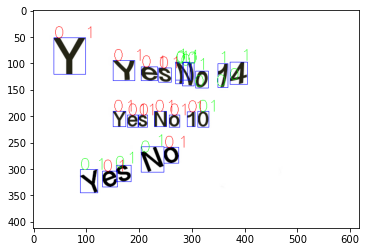

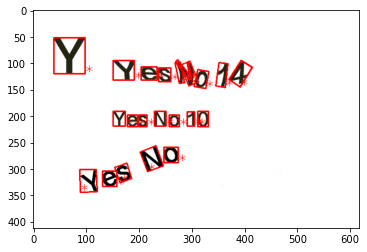

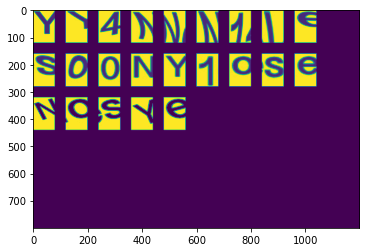

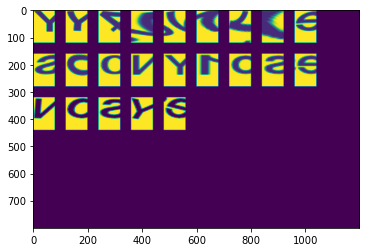

In [27]:
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(target)
plt.show()
plt.imshow(target2)
plt.show()